## Final Assignment - Intrusion detection

### Introduction 
Security is an important issue in today's environments.  
An intrusion detection system (IDS) is a model that can be used to analyze anomalous behavior in a network. NSL-KDD is the updated version of KDD cup 99 dataset. It is used as a benchmark for researchers  to compare different types of Intrusion detection system (IDS) methods or build an intrusion detection system.  
An in depth analysis of the original dataset can be found on these [Tavallaee et al.](https://www.researchgate.net/publication/48446353_A_detailed_analysis_of_the_KDD_CUP_99_data_set) and [Rawat et al.](https://arxiv.org/abs/1910.01114) papers.

In [1]:
# if needed install packages uncommenting the following commands (omit the --no-use if not running on windows)
# !pip install hdbscan --no-use-pep517
# !pip install yellowbrick

In [2]:
import pandas as pd 
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler 
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import classification_report, accuracy_score
from yellowbrick.cluster import KElbowVisualizer
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline

In [3]:
# load the data
train_df = pd.read_csv('NSL-KDDTrain.csv')
test_df = pd.read_csv('NSL-KDDTest.csv')

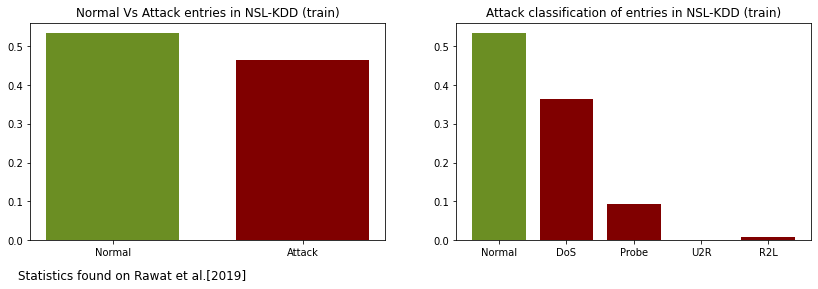

In [4]:
# create graphs based on the statistics found on the aforementioned papers
normal_attack = ['Normal', 'Attack']
normal_attack_height = [67343/train_df.shape[0], (train_df.shape[0]-67347)/train_df.shape[0]]

attack_type = ['Normal', 'DoS', 'Probe', 'U2R', 'R2L']
attack_type_height = [67343/train_df.shape[0], 45927/train_df.shape[0], 11656/train_df.shape[0], 52/train_df.shape[0] , 995/train_df.shape[0]]

plt.figure(figsize=(14,4))
plt.subplot(121)
plt.bar(x=normal_attack, height=normal_attack_height, width=0.7, color=['olivedrab','maroon'])
plt.title('Normal Vs Attack entries in NSL-KDD (train)')
plt.text(x=-0.5, y=-0.1, s='Statistics found on Rawat et al.[2019]', fontsize=12)

plt.subplot(122)
plt.bar(x=attack_type, height=attack_type_height, color=['olivedrab'] + ['maroon']*4)
plt.title('Attack classification of entries in NSL-KDD (train)');

As suggested by the information presented in the graphs above, there is approximately the same number of attack and normal labels.   
So, to tackle the problem in an unlabel manner, **clustering** techniques are suitable. Techniques that cluster the data either into two or five clusters should be prefered (interpreted as _attack vs normal_ or _normal vs attack type_). However, there could be multiple clusters, that "explain" a different partition of the data.  

There are three different types of attribuutes
* Floats
* Integers
* Character

In [5]:
# search for missing values
if train_df.isnull().any().sum() > 0:
    print('There are missing values in the data.')
else:
    print('There are no missing values in the dataset.')

There are no missing values in the dataset.


In [6]:
# split the dataset into numeric and categorical variables
cat_columns = [col for col, dtype in zip(train_df.columns, train_df.dtypes=='object') if dtype]

train_df_num = train_df[[col for col in train_df.columns if col not in cat_columns]]
train_df_cat = train_df[cat_columns]

# do the same for the test set, keep seperate the target variable
test_df_num = test_df[[col for col in train_df.columns if col not in cat_columns]]
test_df_cat = test_df[cat_columns]
y = test_df['target']

### KMeans
KMeans is one of the most well know clustering techniques.  
Kmeans algorithm is an iterative algorithm that tries to split the dataset into K pre-determined (user defined) distinct non-overlapping number of clusters (subgroups) where each data point belongs to only one group.   
It tries to make the intra-cluster data points as similar as possible while also keeping the clusters as different (far) as possible.   
It assigns data points to a cluster such that the sum of the squared distance between the data points and the cluster’s centroid (arithmetic mean of all the data points that belong to that cluster) is at the minimum. The less variation we have within clusters, the more homogeneous (similar) the data points are within the same cluster.  
**Drawbacks**  
k-means is limited to linear cluster boundaries and will often be ineffective if the clusters have complicated geometries. More info [here](https://jakevdp.github.io/PythonDataScienceHandbook/05.11-k-means.html).  
There are more "elegant" techniques that do overcome this issue (for example DBSCAN) but they are a lot more computationaly expensive and they will not be implemented in this workbook.

KMeans calculated the distance between clusters, so it is always prefered to scale the data before doing any clustering.

In [7]:
scaler = StandardScaler ()
train_df_num_scaled = scaler.fit_transform(train_df_num)
test_df_num_scaled = scaler.transform(test_df_num)

In [8]:
# generate the clusters
clust = KMeans(n_clusters=2, random_state=512)
# fit model and predict clusters
clust.fit(train_df_num_scaled)
yhat = clust.predict(test_df_num_scaled)

In [9]:
y_act_int = [1 if x=='attack' else 0 for x in y]

In [10]:
print(classification_report(y_act_int, yhat))

              precision    recall  f1-score   support

           0       0.62      0.98      0.76      9711
           1       0.97      0.55      0.70     12833

    accuracy                           0.73     22544
   macro avg       0.80      0.76      0.73     22544
weighted avg       0.82      0.73      0.73     22544



Above, we have selected 2 clusters, as we want to classify entries as either normal or attack.  
However, in unsupervised methods, we generally do not know the optimal number of clusters. There are various techniques that are used that try to find that number K, based on different criterions.  
A good overview of the most common methods is found [here](https://towardsdatascience.com/cheat-sheet-to-implementing-7-methods-for-selecting-optimal-number-of-clusters-in-python-898241e1d6ad).  
It needs to be noted that it it usual to test with multiple methods, and select K that is the most common between all methods.  
Here, I will be using:
* Elbow method
* Gap statistic
* Silhouette score (for undersampled data, as it is a computationaly expensive method)


The **elbow method** is used to determine the number of clusters K. The clustering algorithm is run multiple times, for an increasing number of cluster choice. The clustering score is then ploted as a function of the number of clusters.  
If the line chart resembles an arm, then the “elbow” (the point of inflection on the curve) is a good indication that the underlying model fits best at that point.

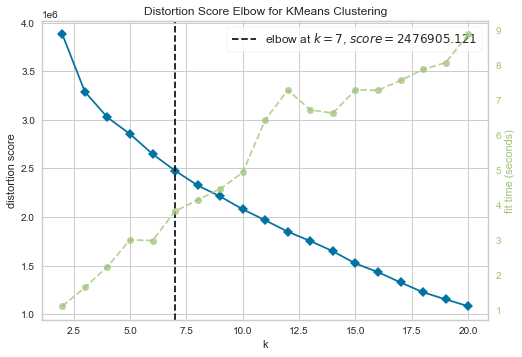

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [13]:
clust = KMeans(random_state=512)
visualizer = KElbowVisualizer(clust, k=(2,21))
visualizer.fit(train_df_num_scaled)
visualizer.show() 

In the graph, **7** is shown as the optimal number of clusters. However, it is not very clear, as **12** could be considered another good K (based on distorion score).    
But, since the test set is labeled, I will be running results of clusters around 7 (range [4, 12]) and plotting the resulting accuracy on the test set.

In [ ]:
Since the test set has data classified into two classes, normal and attack

In [111]:
accuracy_per_k = []

for k in tqdm(range(2, 16)):
    model = KMeans(n_clusters=k, random_state=512, init='k-means++')
    # fit model and predict clusters
    model.fit(train_df_num)
    yhat = model.predict(test_df_num)

    pred_class = [np.nan]*len(y_act_int1)
    for n in range(k):
        clust=[x if x==n else np.nan for x in yhat]
        clust_values = [x for x,y in zip(y_act_int1, clust) if y==n]
        n_attacks = sum(clust_values)
        n_normal = len(clust_values) - n_attacks

        if n_attacks >= n_normal:
            clust = [1 if x==n else x for x in clust]
        else:
            clust = [0 if x==n else x for x in clust]

        # update the predicted class
        pred_class = np.nansum([pred_class, clust], axis=0)

    accuracy_per_k.append(accuracy_score(y_act_int1, pred_class))

100%|██████████| 14/14 [01:18<00:00,  5.57s/it]


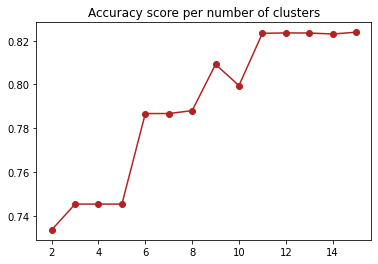

In [112]:
plt.plot(range(2,16), accuracy_per_k, 'o-', color='firebrick')
plt.title('Accuracy score per number of clusters');

### Numeric features + dimensionality reduction

In [ ]:
corr_df = train_df_num.corr()

plt.figure(figsize=(8,8))
ax = sns.heatmap(
      corr_df, 
      cmap='RdGy'
    )
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
plt.title('Correlation plot of variables');

In [ ]:
Some of the variables are highly correlated with each other.
We can reduce the dimensions of the dataset using a dimensionality reduction technique such as SVD.

In [138]:
#pca = PCA(n_components=20)
pca = TruncatedSVD(n_components=15)
train_df_pca = pca.fit_transform(train_df_num)
test_df_pca = pca.transform(test_df_num)
print(f'Explained variance ratio of 20 components: {pca.explained_variance_ratio_.sum()*100:.2f}%')

Explained variance ratio of 20 components: 80.90%


In [139]:
accuracy_per_k_pca_15 = []

for k in tqdm(range(2, 16)):
    model = KMeans(n_clusters=k, random_state=512, init='k-means++')
    # fit model and predict clusters
    model.fit(train_df_pca)
    yhat = model.predict(test_df_pca)

    pred_class = [np.nan]*len(y_act_int1)
    for n in range(k):
        clust=[x if x==n else np.nan for x in yhat]
        clust_values = [x for x,y in zip(y_act_int1, clust) if y==n]
        n_attacks = sum(clust_values)
        n_normal = len(clust_values) - n_attacks

        if n_attacks >= n_normal:
            clust = [1 if x==n else x for x in clust]
        else:
            clust = [0 if x==n else x for x in clust]

        # update the predicted class
        pred_class = np.nansum([pred_class, clust], axis=0)

    accuracy_per_k_pca_15.append(accuracy_score(y_act_int1, pred_class))

100%|██████████| 14/14 [01:05<00:00,  4.66s/it]


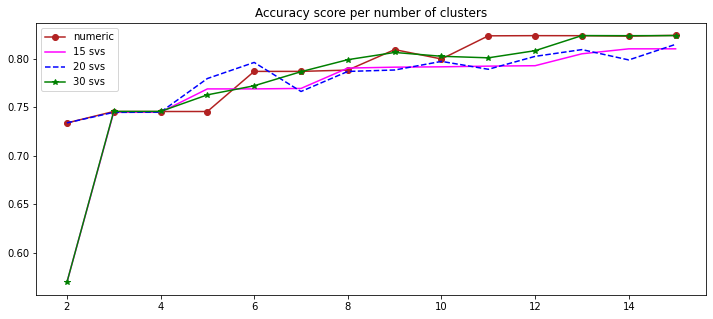

In [140]:
plt.figure(figsize=(12,5))
plt.plot(range(2,16), accuracy_per_k, 'o-', color='firebrick', label='numeric')
plt.plot(range(2,16), accuracy_per_k_pca_15, '-', color='magenta', label='15 svs')
plt.plot(range(2,16), accuracy_per_k_pca, '--', color='blue', label='20 svs')
plt.plot(range(2,16), accuracy_per_k_pca_30, '*-', color='green', label='30 svs')
plt.legend()
plt.title('Accuracy score per number of clusters');

### all numeric features + ohe the categorical ones

In [141]:
from sklearn.preprocessing import OneHotEncoder

In [142]:
drop_enc = OneHotEncoder(drop='first')

In [166]:
cat_cols = [x for x,y in zip(train_df.columns, train_df.dtypes=='object') if y]
train_df_cat = train_df[cat_cols]
test_df_cat = test_df[cat_cols]

In [169]:
train_ohe = drop_enc.fit_transform(train_df_cat)
test_ohe = drop_enc.transform(test_df_cat)

train_full = np.concatenate((train_df_num, train_ohe.todense()), axis=1)
test_full = np.concatenate((test_df_num, test_ohe.todense()), axis=1)

In [180]:
accuracy_per_k_cat = []

for k in tqdm(range(2, 16)):
    model = KMeans(n_clusters=k, random_state=512, init='k-means++')
    # fit model and predict clusters
    model.fit(train_full)
    yhat = model.predict(test_full)

    pred_class = [np.nan]*len(y_act_int1)
    for n in range(k):
        clust=[x if x==n else np.nan for x in yhat]
        clust_values = [x for x,y in zip(y_act_int1, clust) if y==n]
        n_attacks = sum(clust_values)
        n_normal = len(clust_values) - n_attacks

        if n_attacks >= n_normal:
            clust = [1 if x==n else x for x in clust]
        else:
            clust = [0 if x==n else x for x in clust]

        # update the predicted class
        pred_class = np.nansum([pred_class, clust], axis=0)

    accuracy_per_k_cat.append(accuracy_score(y_act_int1, pred_class))

100%|██████████| 14/14 [01:04<00:00,  4.61s/it]


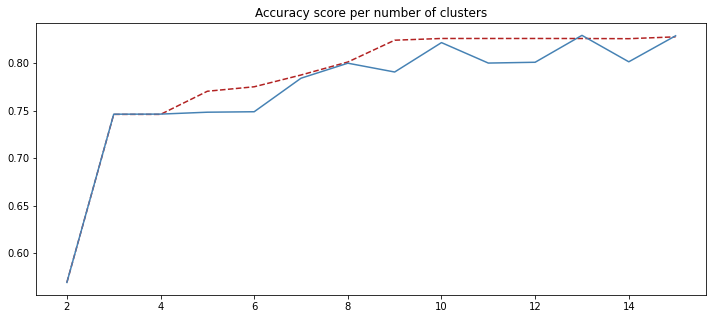

In [182]:
plt.figure(figsize=(12,5))
plt.plot(range(2,16), accuracy_per_k, '--', color='firebrick', label='all feats + ohe')
plt.plot(range(2,16), accuracy_per_k_cat, '-', color='steelblue', label='all - service + ohe')
plt.title('Accuracy score per number of clusters');

_service_ has many distinct values, test what happens if we omit it completely

In [179]:
train_df_cat = train_df[['protocol_type', 'flag']]
test_df_cat = test_df[['protocol_type', 'flag']]

train_ohe = drop_enc.fit_transform(train_df_cat)
test_ohe = drop_enc.transform(test_df_cat)

train_full = np.concatenate((train_df_num, train_ohe.todense()), axis=1)
test_full = np.concatenate((test_df_num, test_ohe.todense()), axis=1)

### use only a subset of the training dataset

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
X_train, _ = train_test_split(train_df, test_size=0.70, random_state=58)

In [10]:
train_df_num = X_train[[col for col, dtype in zip(X_train.columns, X_train.dtypes=='object') if not dtype]]

scaler = MinMaxScaler()
train_df_num = scaler.fit_transform(train_df_num)

test_df_num = test_df[[col for col, dtype in zip(test_df.columns, test_df.dtypes=='object') if not dtype]]
test_df_num = scaler.transform(test_df_num)

In [11]:
accuracy_per_kmm_30 = []

for k in tqdm(range(2, 16)):
    model = KMeans(n_clusters=k, random_state=512, init='k-means++')
    # fit model and predict clusters
    model.fit(train_df_num)
    yhat = model.predict(test_df_num)

    pred_class = [np.nan]*len(y_act_int1)
    for n in range(k):
        clust=[x if x==n else np.nan for x in yhat]
        clust_values = [x for x,y in zip(y_act_int1, clust) if y==n]
        n_attacks = sum(clust_values)
        n_normal = len(clust_values) - n_attacks

        if n_attacks >= n_normal:
            clust = [1 if x==n else x for x in clust]
        else:
            clust = [0 if x==n else x for x in clust]

        # update the predicted class
        pred_class = np.nansum([pred_class, clust], axis=0)

    accuracy_per_kmm_30.append(accuracy_score(y_act_int1, pred_class))

100%|██████████| 14/14 [00:23<00:00,  1.65s/it]


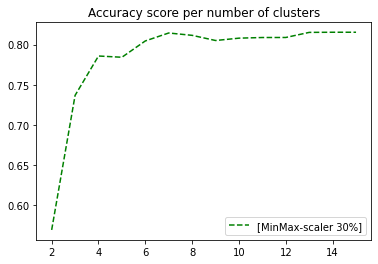

In [12]:
#plt.plot(range(2,16), accuracy_per_k, '--', color='firebrick', label='[std-scaler 50%]')
#plt.plot(range(2,16), accuracy_per_kmm, '--', color='steelblue', label='[MinMax-scaler 50%]')
plt.plot(range(2,16), accuracy_per_kmm_30, '--', color='green', label='[MinMax-scaler 30%]')
plt.legend()
plt.title('Accuracy score per number of clusters');

In [13]:
### HDBSCAN -->slow

In [16]:
#from hdbscan import HDBSCAN

In [17]:
# model = HDBSCAN()
# # fit model and predict clusters
# model.fit(train_df_num)

HDBSCAN()

The algorithms predicts **1225 clusters** using HDBSCAN!!

In [18]:
# model.labels_.max()

1225

### aglomerative clustering   
--> very slow, even when using 30% of the training dataset and the fast implementation (O(N^2)) from fastcluste.  
No results, even after 30 minutes.

In [20]:
# from fastcluster import linkage
# model = linkage(train_df_num, method='ward')